# Import Packages Needed For Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Read In the Data Provided by PDP Databases 
**We used all years available, and the analytical results category.***
- LINK: https://www.ams.usda.gov/datasets/pdp/pdpdata

In [3]:
PDP_Data = pd.read_csv('PDP_Positive_Detects_1994-2021.csv',low_memory = False)

PDP_Data.head()

Sample ID Commod Pesticide Code  Pesticide Name Test Class  \
0  CA0307280363AACA1      AA            160    Chlorpyrifos          C   
1  CA0310280484AACA1      AA             83  O-Phenylphenol          I   
2  CA0311250391AACA1      AA             83  O-Phenylphenol          I   
3  FL0308220056AAFL1      AA            160    Chlorpyrifos          C   
4  MI0307280000AAFL1P     AA            160    Chlorpyrifos          C   

   Concentration     LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean  \
0         0.0250  0.0040   M         C         M      NaN          M    O   
1         0.0170  0.0100   M        MO       NaN       QV          H    O   
2         0.0170  0.0100   M        MO       NaN       QV          H    O   
3         0.0063  0.0038   M       NaN       NaN       Q           M    O   
4         0.0170  0.0038   M         D       NaN      NaN          M    O   

  Extract  Determ EPA Tolerance (ppm)  
0     552     2.0                   5  
1     550     7.0                  NT  
2     550     7.0                  NT  
3     802    60.0                   5  
4     551    60.0                   5

# Data Preprocessing

### We want to compare the EPA thresholds column to the level of concentration (of the pesticide residue) measurement column.


In [4]:
# They can be M = PPM, B = PPB, and T = PPT, let's check unique vals:
print("Unique Tolerances:",PDP_Data["pp_"].unique())

Unique Tolerances: ['M' 'T']


### Because the EPA tolerance is measured in Parts Per Million (PPM) we need to covert the values in the Concentration column by the type in the pp_ column, such that they're all in this unit form:

In [5]:
# First we need to create a method to convert the data:
# ppt to ppm is 1 to 0.000001, so xppm = xppt / 10^6
def ppt_to_ppm(data_col):
    """
    Converts PPT to PPM
    """
    ppm = []
    for i in data_col:
        ppm.append(i/0.000001)
    return ppm

# Since we only have PPM (What we need) and PPT, we convert all PPT values:
# If the pp_ column contains T instead of M, convert it, otherwise, stay the same.
PDP_Data['PPM'] = np.where(PDP_Data["pp_"].str.contains('T', regex=False), 
                           ppt_to_ppm(PDP_Data["Concentration"]), PDP_Data["Concentration"])

PDP_Data["PPM"] # Check column added.

0         0.0250
1         0.0170
2         0.0170
3         0.0063
4         0.0170
           ...  
571217    0.0110
571218    0.0025
571219    0.0570
571220    0.0025
571221    0.0025
Name: PPM, Length: 571222, dtype: float64

### The EPA Column is in char format because it contains many different thresholds, all in ppm, for the tolerances. Because of this, we need to extract the numerical values from this column to compare to the PPM column for each commodity.

In [6]:
print("Unique EPA Tolerance Values:",PDP_Data["EPA Tolerance (ppm)"].unique())

Unique EPA Tolerance Values: ['5' 'NT' '0.6' '10' '25' '1.5' '1' '0.3' '3' '2' '1.7' '15' '1.2' '12'
 '0.5' '0.1' '7' '4' '0.8' '0.02' '0.2' '0.4' '0.75' '0.05' '14' '10.0 PP'
 '5.0 PH' '25.0 TP' '2.0 TP' '8' '0.1 AL' '0.7' '0.25' '0.03 AL' '0.15'
 '0.01' '0.5 AL' '13' '0.04' '5.0 R' '15 TP' '2.5' '1.6' '1.8' '5 AL'
 '0.3 AL' '0.2 AL' '7 AL' '3.5' '6' '20' '0.9' '0.1 FF' '20.0 TP'
 '0.01 FF' '0.30 TP' '1.3' '1.0 TP' '1.0 FU' '3.0 TP' '4.0 PH' '3.0 PH'
 '0.1 EP' '0.5 FU' '2.0 FU' '0.40 IM' '10 FU' '3.0 FU' '0.2 FU' '1.4' '30'
 '4.5' '1.9' '9' '4.5 TP' '10 FF' '1 AL' '0.03' '50' '0.05 FF' '0.02 TP'
 '40' '0.02 FF' '150' '90' '400' '5.0 IN' '200' '80' '5.0 FF' '100'
 '1.25 AL' '6.25' '85' '0.015' '22' 'EX' '45' '29' '60' '35' '0.5 R'
 '10 TP' '11' 'EX3' '0.03 IN' '4.0 TP' '0.08' '21' '5 FF' 'NR' '15.0 FU'
 '0.2 TP' '10 EP' '15.0 PH' '10 PH' '0.02 AL' '0.09' '0.01 AL' '8 PH'
 '3 AL' '0.45' '3.0 AL' '10.0 PH' '0.05 AL' '0.06' '0.25 TP' '5.0 TP' nan
 '20 IT' '2.0 IN' '0.05 TP' '2.0 IT' '2.0 

### Extracting the numeric values from the EPA Tolerance Column for comparison to PPM Column:
- While replacing No Tolerance values or non-numeric thresholds with NAN in the EPA columns as well.

In [7]:
EPA = list(PDP_Data["EPA Tolerance (ppm)"])
numbers = []
for i in EPA:
    if isinstance(i,str):
        # Find number or decimal in the column, exlude nan or otherwise:
        match = re.findall(r'\d+(?:\.\d+)?', i)
        if len(match) == 1:
            numbers.append(float(match[0]))
        elif len(match) == 2:
            numbers.append(float(match[0])/float(match[1]))
        else:
            numbers.append(np.nan)
    else:
        numbers.append(np.nan)
        
print(len(numbers))
print(len(EPA)) # Should be same lengths! 

print(EPA[0:10])
print(numbers[0:10])

571222
571222
['5', 'NT', 'NT', '5', '5', '5', '5', '5', 'NT', '0.6']
[5.0, nan, nan, 5.0, 5.0, 5.0, 5.0, 5.0, nan, 0.6]


**Now we need to remove columns where the EPA tolerance is missing, we don't want to estimate by average for the commodities EPA tolerance because this is different for every item, and assigned by the FDA.**

Values can be NT = No Tolerance, or AL = Action Level (Threshold) All values will be measured in PPM. They were all replaced by np.nan in the previous block of code.

In [8]:
PDP_Data["New EPA"] = numbers
PDP_Data["New EPA"]

0          5.0
1          NaN
2          NaN
3          5.0
4          5.0
          ... 
571217     NaN
571218    10.0
571219     NaN
571220    10.0
571221    10.0
Name: New EPA, Length: 571222, dtype: float64

In [9]:
PDP_Data = PDP_Data.dropna()
PDP_Data["New EPA"]

106       10.0
128       10.0
135       10.0
155       10.0
159       10.0
          ... 
570721     2.0
570726     2.0
570730     2.0
570732     2.0
570797     0.1
Name: New EPA, Length: 9305, dtype: float64

### Finally we can do the PPM column comparison to the New EPA thresholds converted column:

In [10]:
# Extract columns where PPM greater than New EPA Value
Exceeds_Threshold = PDP_Data[PDP_Data.PPM.gt(PDP_Data["New EPA"])]
Exceeds_Threshold.head()

Sample ID Commod Pesticide Code  \
39735   FL0201220001ASFL1      AS            AEL   
39737   FL0201220048ASFL1      AS            AEL   
112907  CA9905110146CNCA1      CN            204   
112917  CA9905110276CNCA1      CN            204   
115040  NY0508030071CNTX1      CN            204   

                                           Pesticide Name Test Class  \
39735   Cyhalothrin, Total (Cyhalothrin-L + R157836 ep...          O   
39737   Cyhalothrin, Total (Cyhalothrin-L + R157836 ep...          O   
112907                                           Acephate          C   
112917                                           Acephate          C   
115040                                           Acephate          C   

        Concentration    LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean  \
39735           0.140  0.015   M         D         M        X          M    O   
39737           0.093  0.015   M         D         M        X          M    O   
112907          0.088  0.002   M         D         M        X          H    O   
112917          0.099  0.002   M         D         M        X          M    O   
115040          0.210  0.005   M        C         S        X          M     O   

       Extract  Determ EPA Tolerance (ppm)    PPM  New EPA  
39735      551    60.0                0.01  0.140     0.01  
39737      551    60.0                0.01  0.093     0.01  
112907     552     2.0                0.02  0.088     0.02  
112917     552     2.0                0.02  0.099     0.02  
115040      15     2.0                0.02  0.210     0.02

### We then plot the finished results:

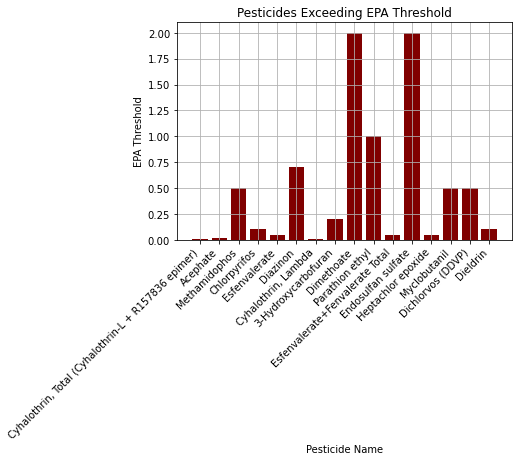

In [11]:
plt.bar(Exceeds_Threshold["Pesticide Name"],Exceeds_Threshold["New EPA"],color = "maroon")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Pesticide Name")
plt.ylabel("EPA Threshold")
plt.grid("lightgrey")
plt.title("Pesticides Exceeding EPA Threshold")
plt.show()

# The resulting figure displays the pesticides that exceed their assigned FDA/EPA limit, such as Dimethoate, Diazinon, e.t.c.

# Exporting the file:

In [12]:
plt.savefig('Exceed_EPA_Pest.png')

<Figure size 432x288 with 0 Axes>